In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [63]:
def svr_forecast_helper(model, last_window, horizon):
    predictions = []
    input_sequence = last_window.copy()

    for _ in range(horizon):
        input_array = np.array(input_sequence[-len(last_window):]).reshape(1, -1)
        next_prediction = model.predict(input_array)[0]
        predictions.append(next_prediction)
        input_sequence.append(next_prediction)
    
    return predictions

In [ ]:
# copied from arima utils

def rolling_origin_eval_prep(df_train, df_test, horizon):
    train_split, test_split = [], [] # initialize empty lists to store each train and test split
    for i in range(0, len(df_test) - horizon + 1):
        curr_train = pd.concat([df_train, df_test.iloc[:i]], axis = 0)
        curr_test = df_test.iloc[i:i + horizon] # create a test windos from i to i+horizon, meaning select the next "horizon step" of test data starting from i
        train_split.append(curr_train)
        test_split.append(curr_test)
    return train_split, test_split

def cal_smape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast) # convert actual and forecasted values to numpy arrays
    denominator = (np.abs(actual) + np.abs(forecast)) / 2
    difference = np.abs(actual - forecast) / denominator
    difference = np.where(denominator == 0, 0, difference) # to avoid dividing by 0 or NaN
    return 100 * np.mean(difference)


def evaluate(actual, forecast):
    mae = round(mean_absolute_error(actual, forecast), 3)
    mse = round(mean_squared_error(actual, forecast), 3)
    rmse = round(np.sqrt(mse), 3)
    smape = round(cal_smape(actual, forecast), 3)
    return mae, mse, rmse, smape

In [ ]:
df_train, df_test = data_prep(test_size, dataset)
train_split, test_split = rolling_origin_eval_prep(df_train, df_test, horizon)

forecast_df = pd.DataFrame()
forecast_df["date"] = df_test.index
forecast_df["y"] = df_test["y"].values

all_metrics = []

window_size = 3

for i, (curr_train, curr_test) in enumerate(zip(train_split, test_split)):

    y_train = curr_train["y"].values

    # Creating the sliding window training data
    X_train, y_target = [], []
    for j in range(len(y_train) - window_size):
        X_train.append(y_train[j:j + window_size])
        y_target.append(y_train[j + window_size])
    
    model = SVR()
    model.fit(X_train, y_target)

    last_window = list(y_train[-window_size:])
    forecast = svr_forecast_helper(model, last_window, horizon)

    i_forecast = np.concatenate([np.repeat(np.nan, i), forecast, np.repeat(np.nan, len(df_test) - i - horizon)])
    forecast_df[f"{i}"] = i_forecast

    mae, mse, rmse, smape = evaluate(actual, forecast)

    meta_dict = {"dataset": dataset,
                "test_size": test_size,
                "horizon": horizon,
                "iter": i,
                "mae": round(mae),
                "mse": round(mse),
                "rmse": round(rmse),
                "smape": round(smape)}

In [70]:
forecast_df

,date,y,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
0,0,-1.3,-1.254131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-1.7,-1.160620,-1.216488,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-2.0,-0.970579,-1.040506,-1.627814,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,-1.8,-0.715982,-0.792847,-1.531260,-2.028125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,-2.0,-0.417106,-0.500144,-1.320563,-1.994680,-1.651120,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,-0.4,NaN,-0.176396,-1.074338,-1.892553,-1.393324,-1.885957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,4.3,NaN,NaN,-0.784146,-1.762043,-1.118894,-1.812819,0.231679,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,9.8,NaN,NaN,NaN,-1.606576,-0.805185,-1.672832,1.149634,6.237894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,12.1,NaN,NaN,NaN,NaN,-0.473578,-1.528035,1.821465,8.078514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,13.4,NaN,NaN,NaN,NaN,NaN,-1.362273,2.487144,9.374025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


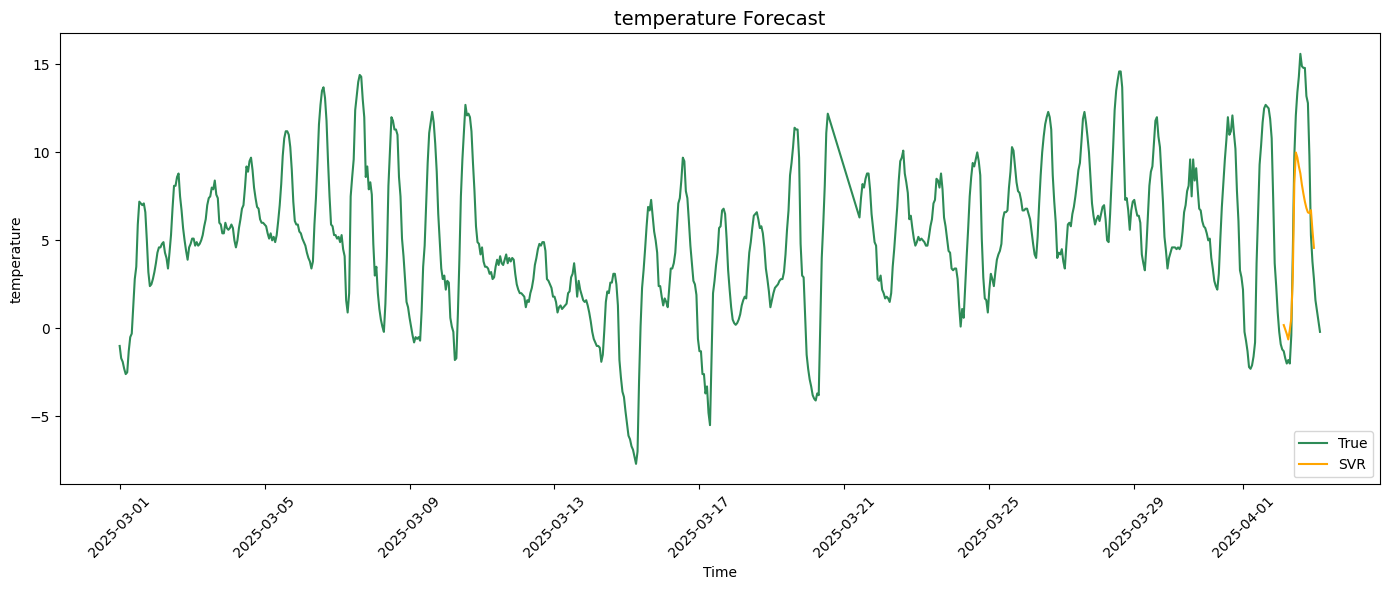

In [ ]:


true_y_train = df_train["temperature"]
true_y_test = df_test["temperature"].iloc[:len(forecast_df)]
true_y = pd.concat([true_y_train, true_y_test]).reset_index(drop=True)

dates = pd.concat([df_train["date"], df_test["date"].iloc[:len(forecast_df)]]).reset_index(drop=True)

svr_forecast = forecast_df.drop(columns=["date", "y"]).mean(axis=1).iloc[:len(df_test)].reset_index(drop=True)
forecast_dates = df_test["date"].iloc[:len(svr_forecast)].reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(dates, true_y, label="True", color="seagreen")
plt.plot(forecast_dates, svr_forecast, label="SVR", color="orange")

plt.legend(loc="lower right")
plt.xlabel('Time')
plt.ylabel('temperature')
plt.title('temperature Forecast', fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [84]:
# grid search

# params? kernel, gamme, C, epsilon, windows size
# model = SVR(kernel='rbf', gamma=0.5, C=10, epsilon=0.05)

param_dict = {"C": [0.1, 1, 10, 100],
                "epsilon": [0.01, 0.1, 0.5],
                "gamma": ["scale", "auto", 0.1, 0.5]}
windows = [5, 10, 24] #?

In [81]:
from sklearn.model_selection import GridSearchCV

In [ ]:
svr = SVR()
grid_search = GridSearchCV(estimator = svr, param_grid = param_dict, verbose = 2, n_jobs = -1)

grid_search.fit(...)
best_csv = grid_search.best_estimator_
